In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import Callback

2025-01-14 17:52:05.869119: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-14 17:52:05.877033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736857325.886483  105017 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736857325.889370  105017 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 17:52:05.898997: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
tf.config.run_functions_eagerly(True)

In [4]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [5]:
tf.keras.backend.clear_session() 

In [6]:
class RealTimePlottingCallback(Callback):
    def __init__(self):
        super().__init__()
        self.epochs = []
        self.losses = []
        self.psnrs = []
        self.ssims = []
        self.snrs = []

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch)
        self.losses.append(logs['loss'])
        
        # Add the values for PSNR, SSIM, and SNR (modify these based on your metrics' names)
        if 'psnr' in logs:
            self.psnrs.append(logs['psnr'])
        else:
            self.psnrs.append(None)
        
        if 'ssim' in logs:
            self.ssims.append(logs['ssim'])
        else:
            self.ssims.append(None)
        
        if 'snr' in logs:
            self.snrs.append(logs['snr'])
        else:
            self.snrs.append(None)

        # Clear the plot and re-draw for each epoch
        plt.clf()
        
        # Plotting Loss
        plt.subplot(2, 2, 1)
        plt.plot(self.epochs, self.losses, label='Loss', color='red')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')

        # Plotting PSNR
        if self.psnrs[0] is not None:
            plt.subplot(2, 2, 2)
            plt.plot(self.epochs, self.psnrs, label='PSNR', color='blue')
            plt.xlabel('Epoch')
            plt.ylabel('PSNR')
            plt.title('PSNR')

        # Plotting SSIM
        if self.ssims[0] is not None:
            plt.subplot(2, 2, 3)
            plt.plot(self.epochs, self.ssims, label='SSIM', color='green')
            plt.xlabel('Epoch')
            plt.ylabel('SSIM')
            plt.title('SSIM')

        # Plotting SNR
        if self.snrs[0] is not None:
            plt.subplot(2, 2, 4)
            plt.plot(self.epochs, self.snrs, label='SNR', color='purple')
            plt.xlabel('Epoch')
            plt.ylabel('SNR')
            plt.title('SNR')

        # Adjust the layout and show the plot
        plt.tight_layout()
        plt.pause(0.1)

In [7]:
class PSNR(tf.keras.metrics.Metric):
    def __init__(self, name='psnr', **kwargs):
        super(PSNR, self).__init__(name=name, **kwargs)
        self.psnr_value = self.add_weight(name='psnr_value', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        max_pixel = 1.0
        psnr_value = tf.image.psnr(y_true, y_pred, max_val=max_pixel)
        self.psnr_value.assign(tf.reduce_mean(psnr_value))  # Update the state variable

    def result(self):
        return self.psnr_value

In [8]:
class SSIM(tf.keras.metrics.Metric):
    def __init__(self, name='ssim', **kwargs):
        super(SSIM, self).__init__(name=name, **kwargs)
        self.ssim_value = self.add_weight(name='ssim_value', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        ssim_value = tf.image.ssim(y_true, y_pred, max_val=1.0)
        self.ssim_value.assign(tf.reduce_mean(ssim_value))  # Update the state variable

    def result(self):
        return self.ssim_value

In [9]:
class SignalNoiseRatio(tf.keras.metrics.Metric):
    def __init__(self, name='snr', **kwargs):
        super(SignalNoiseRatio, self).__init__(name=name, **kwargs)
        self.snr_value = self.add_weight(name='snr_value', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        noise = tf.math.reduce_std(y_true - y_pred, axis=[1, 2])
        signal = tf.math.reduce_std(y_true, axis=[1, 2])
        snr_value = signal / noise
        self.snr_value.assign(tf.reduce_mean(snr_value))  # Update the state variable

    def result(self):
        return self.snr_value



In [10]:
def build_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Initial Image Head
    x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    
    for _ in range(1):
        x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(3, (3, 3), strides=(1, 1), padding='same')(x)

    model = models.Model(inputs, x)
    return model


In [11]:
def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

In [12]:
def preprocess_image(image_path, target_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 127.5 - 1.0  # Normalize to [-1, 1]
    return image

In [13]:
def load_dataset(lr_path, hr_path, lr_shape, hr_shape, batch_size):
    lr_files = tf.data.Dataset.list_files(os.path.join(lr_path, "*.png"), shuffle=True)
    hr_files = tf.data.Dataset.list_files(os.path.join(hr_path, "*.png"), shuffle=True)

    lr_images = lr_files.map(
        lambda x: preprocess_image(x, lr_shape[:2]), num_parallel_calls=tf.data.AUTOTUNE
    )
    hr_images = hr_files.map(
        lambda x: preprocess_image(x, hr_shape[:2]), num_parallel_calls=tf.data.AUTOTUNE
    )

    dataset = tf.data.Dataset.zip((lr_images, hr_images))
    dataset = dataset.shuffle(buffer_size=256)  # Reduce shuffle buffer
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch for performance
    return dataset

In [14]:
def split_dataset(dataset, val_size=0.2):
    total_size = len(dataset)
    val_size = int(total_size * val_size)
    train_size = total_size - val_size

    # Split the dataset
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)

    return train_dataset, val_dataset

In [15]:
checkpoint_callback = ModelCheckpoint(
    'super_resolution_model.weights.keras',
    monitor='val_psnr',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1  
)

early_stopping_callback = EarlyStopping(
    monitor='val_psnr',
    mode='max',
    patience=3,
    verbose=True,
    min_delta=0.1
)

In [16]:
LOW_RES_PATH = "./LR"
HIGH_RES_PATH = "./HR"
LR_SHAPE = (128, 64, 3)
HR_SHAPE = (512, 256, 3)
BATCH_SIZE = 4
EPOCHS = 1000

In [17]:
dataset = load_dataset(LOW_RES_PATH, HIGH_RES_PATH, LR_SHAPE, HR_SHAPE, BATCH_SIZE)
train_data, val_data = split_dataset(dataset, val_size=0.2)

I0000 00:00:1736857327.553580  105017 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5820 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/c3ilab/Documents/lebc/.venv/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [18]:
input_shape = LR_SHAPE 
model = build_model(input_shape)

In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 64, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 256, 128, 128)  │         6,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 128, 512)  │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 128, 512)  │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 512, 256, 256)  │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512, 256, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 512, 256, 3)    │         6,915 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,704,515 (10.32 MB)

 Trainable params: 2,702,723 (10.31 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=mse_loss,
    metrics=[PSNR(), SSIM(), SignalNoiseRatio()]
)

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 64, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 256, 128, 128)  │         6,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 128, 512)  │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 128, 512)  │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 512, 256, 256)  │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512, 256, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 512, 256, 3)    │         6,915 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,704,515 (10.32 MB)

 Trainable params: 2,702,723 (10.31 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [22]:
realtime_plotting_callback = RealTimePlottingCallback()

Epoch 1/1000


I0000 00:00:1736857330.737284  105017 cuda_dnn.cc:529] Loaded cuDNN version 90300


5680/5680 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 0.3338 - psnr: 5.7063 - snr: 0.9643 - ssim: 0.0070
Epoch 1: val_psnr improved from -inf to 3.96468, saving model to super_resolution_model.weights.keras


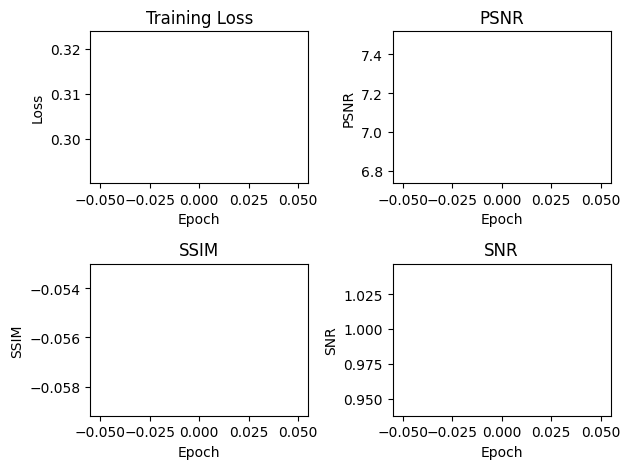

5680/5680 ━━━━━━━━━━━━━━━━━━━━ 1776s 311ms/step - loss: 0.3338 - psnr: 5.7066 - snr: 0.9643 - ssim: 0.0070 - val_loss: 0.2970 - val_psnr: 3.9647 - val_snr: 0.9913 - val_ssim: 0.0512
Epoch 2/1000
5680/5680 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 0.2992 - psnr: 5.8339 - snr: 0.9862 - ssim: 0.0073

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_callback, realtime_plotting_callback]
)

In [28]:
import numpy as np

In [33]:
from tensorflow.keras.preprocessing import image

In [34]:
def preprocess_image(img_path, target_size=(256, 256)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image (if needed)
    return img_array

In [45]:
def predict_on_image(img_path):
    img_array = preprocess_image(img_path)
    
    # Predict the output
    prediction = model.predict(img_array)
    
    # Display original image and predicted output
    original_img = image.load_img(img_path)
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_img)

    prediction+=1.0
    prediction*=127.0
    prediction = prediction.astype(np.int8)
    print(prediction.dtype)
    # Predicted Image
    plt.subplot(1, 2, 2)
    plt.subplot(1, 2, 2)
    plt.title("Predicted Image")
    plt.imshow(prediction[0])  # The output is batch_size x height x width x channels
    plt.show()

    return prediction

In [ ]:
img_path = './LR1/0001.png'
prediction = predict_on_image(img_path)

In [ ]:
img_path = './LR1/0007.png'
prediction = predict_on_image(img_path)